# Resource Working Behavior Analysis

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from neo4j import GraphDatabase
import pm4py
from datetime import datetime, date
from datetime import datetime

# High-Level Event Log Construction

In [27]:
load_dotenv()
uri = os.getenv('NEO4J_URI')
username = os.getenv('NEO4J_USER')
password = os.getenv('NEO4J_PASSWORD')

cypher_all_data = """
    MATCH (k:Kit)<-[:CORR]-(e:Event)-[:CORR]->(hbl:HighLevelBatch)
    
    WITH 
    date(e.timestamp) as date,
    e.timestamp as event_timestamp,
    e.activity as event_activity,
    e.batch as event_batch,
    k.kitId as kitId, 
    ID(hbl) as hbl_id,
    hbl.date as hbl_date,
    hbl.activity_name as hbl_activity,
    hbl.sysId as resource,
    hbl.corr_batch_numbers as hbl_corr_batch_numbers,
    hbl.workTogether as work_together
    RETURN date, event_timestamp, event_activity, event_batch, kitId, hbl_id, hbl_date, hbl_activity, resource, hbl_corr_batch_numbers, work_together

    ORDER BY date,event_timestamp, resource 
"""

def cypher_all_data_func(uri, username, password, cypher_all_data):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_all_data)
        data = result.data()
        return data
    
results_cypher_all_data = cypher_all_data_func(uri, username, password, cypher_all_data)

def convert_neo4j_date_to_python(neo4j_date):
    # Converting neo4j.time.Date to Python's datetime.date
    return date(
        year=neo4j_date.year,
        month=neo4j_date.month,
        day=neo4j_date.day
    )

def convert_neo4j_datetime_to_python(neo4j_datetime):
    # Converting neo4j.time.DateTime to Python's datetime.datetime
    return datetime(
        year=neo4j_datetime.year,
        month=neo4j_datetime.month,
        day=neo4j_datetime.day,
        hour=neo4j_datetime.hour,
        minute=neo4j_datetime.minute,
        second=neo4j_datetime.second,
        microsecond=neo4j_datetime.nanosecond // 1000,  # Convert nanoseconds to microseconds
        tzinfo=neo4j_datetime.tzinfo
    )
df_hlb = pd.DataFrame(results_cypher_all_data)

df_hlb['date'] = df_hlb['date'].apply(convert_neo4j_date_to_python)
df_hlb['date'] = df_hlb['date'].apply(lambda d: d.strftime('%Y-%m-%d'))

df_hlb['hbl_date'] = df_hlb['hbl_date'].apply(convert_neo4j_date_to_python)
df_hlb['hbl_date'] = df_hlb['hbl_date'].apply(lambda d: d.strftime('%Y-%m-%d'))

df_hlb['event_timestamp'] = df_hlb['event_timestamp'].apply(convert_neo4j_datetime_to_python)

df_hlb['resource'] = df_hlb['resource'].astype(str)
df_hlb['work_together'] = df_hlb['work_together'].astype(str)

df_hlb['hbl_activity'] = df_hlb['hbl_activity'].astype(str)
df_hlb['hbl_activity'] = df_hlb['hbl_activity'].str.strip('[]')
df_hlb['hbl_activity'] = df_hlb['hbl_activity'].apply(lambda x: x.strip("[]").replace("'", ""))

df_hlb['hbl_corr_batch_numbers'] = df_hlb['hbl_corr_batch_numbers'].astype(str)
df_hlb['hbl_corr_batch_numbers'] = df_hlb['hbl_corr_batch_numbers'].str.strip('[]')

In [28]:
df_hlb = df_hlb.sort_values(by=['date', 'resource', 'event_timestamp'], ascending=True)

hbl_global_id = 0
previous_hbl_id = None

def assign_hbl_global_id(row):
    global hbl_global_id, previous_hbl_id
    if row['hbl_id'] != previous_hbl_id:
        hbl_global_id += 1
        previous_hbl_id = row['hbl_id']
    return hbl_global_id

df_hlb['hbl_global_id'] = df_hlb.apply(assign_hbl_global_id, axis=1)

unique_activities = df_hlb['event_activity'].unique()

# Add columns for each unique activity initialized to zero
for activity in unique_activities:
    df_hlb[f'kits_{activity}'] = 0

df_hlb_group = df_hlb.groupby('hbl_global_id')

# Calculation of EnteredBuffer, Start and Buffer Values

Time Bins Creation

In [29]:
df = pd.read_csv(os.getenv('EVENT_LOG'))

# Convert 'timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['timestamp'])

# Create a separate DataFrame for time bins
time_bins = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='30T')
time_bins_df = pd.DataFrame({'time_bin_start': time_bins[:-1], 'time_bin_end': time_bins[1:]})

/var/folders/1r/3fk_x7p96299qsbl_p0t7v6h0000gn/T/ipykernel_1962/1034945142.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_bins = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='30T')


In [30]:
# Add the specified columns to the time_bins_df
activity_columns = [
    'Entrada Material Sucio',
    'Cargado en carro  L+D',
    'Carga L+D iniciada',
    'Carga L+D liberada',
    'Montaje',
    'Producción  montada',
    'Composición de cargas',
    'Carga de esterilizador liberada',
    'Comisionado'
]
for col in activity_columns:
    time_bins_df['Start ' + col] = 0
    if col != 'Entrada Material Sucio':
        time_bins_df['Buffer before ' + col] = 0
    time_bins_df[col] = 0

### Assign Start Values and EnteredBuffer

In [31]:
def update_time_bins(df, time_bins_df):
    for _, group in df.groupby('runId'):
        group = group.sort_values('timestamp')
        
        for i, (_, row) in enumerate(group.iterrows()):
            timestamp = row['timestamp']
            activity = row['activity']

            # if (pd.to_datetime('2022-03-31 14:21:00+00:00') <= timestamp) and (pd.to_datetime('2022-03-31 14:51:00+00:00') > timestamp) and activity == 'Cargado en carro  L+D' :
            #     display(group)
            
            # Find the appropriate time bin
            bin_index = time_bins_df[(time_bins_df['time_bin_start'] <= timestamp) & (time_bins_df['time_bin_end'] > timestamp)].index
            if not bin_index.empty:
                bin_index = bin_index[0]
                
                # Update the activity count
                if activity in time_bins_df.columns:
                    time_bins_df.at[bin_index, activity] += 1
                
                if i > 0:
                    previous_col = f"Buffer before {activity}"
                    # Find the time bin for the previous row's timestamp
                    prev_timestamp = group.iloc[i-1]['timestamp']
                    prev_bin_index = time_bins_df[(time_bins_df['time_bin_start'] <= prev_timestamp) & (time_bins_df['time_bin_end'] > prev_timestamp)].index
                    if not prev_bin_index.empty:
                        prev_bin_index = prev_bin_index[0]
                        if previous_col in time_bins_df.columns:
                            time_bins_df.at[prev_bin_index, previous_col] += 1
                if i == 0:
                    start_col = f"Start {activity}"
                    if start_col in time_bins_df.columns:
                        time_bins_df.at[bin_index, start_col] += 1
    
    return time_bins_df

# Update the time bins with the df data
updated_time_bins_df = update_time_bins(df, time_bins_df)

### Calculate the Buffer Values

In [32]:
def update_buffer_columns(df):
    # Identify buffer columns and corresponding activity columns
    buffer_columns = [col for col in df.columns if col.startswith('Buffer before')]
    start_columns = {buffer_col: buffer_col.replace('Buffer before ', 'Start ') for buffer_col in buffer_columns}
    activity_columns = {buffer_col: buffer_col.replace('Buffer before ', '') for buffer_col in buffer_columns}

    # Iterate through each row starting from the second row (index 1)
    for i in range(1, len(df)):
        for buffer_col in buffer_columns:
            start_col = start_columns[buffer_col]
            activity_col = activity_columns[buffer_col]
            
            # Get the current buffer column value
            current_value = df.at[i, buffer_col]
            previous_start_value = df.at[i - 1, start_col]
            previous_buffer_value = df.at[i - 1, buffer_col]
            previous_activity_value = df.at[i - 1, activity_col]
            
            new_value = current_value + previous_buffer_value + previous_start_value - previous_activity_value 

            if new_value < 0:
                raise Exception("new value negative")
            
            df.at[i, buffer_col] = new_value

    return df

# Assuming updated_time_bins_df is your DataFrame
recalculated_time_bins_df = update_buffer_columns(updated_time_bins_df)
timeseries_events = recalculated_time_bins_df.copy()



# High-Level Event Log Processed Kits Calculation

In [33]:
# Function to count unique kits for each activity and count activity occurrences
def count_unique_kits_and_occurrences(group, activities):
    result = {f'kits_{activity}': 0 for activity in activities}
    presence_result = {f'hlb_{activity}': 0 for activity in activities}
    for activity in activities:
        result[f'kits_{activity}'] = group[group['event_activity'] == activity]['kitId'].nunique()
        presence_result[f'hlb_{activity}'] = group[group['event_activity'] == activity].shape[0]
    return pd.Series({**result, **presence_result})

# Apply the function to each group
df_hlb_counts = df_hlb_group.apply(lambda group: count_unique_kits_and_occurrences(group, unique_activities)).reset_index()

# Aggregate the original DataFrame
df_hlb_agg = df_hlb_group.agg(
    hbl_date=('hbl_date', 'first'),
    hbl_activity=('hbl_activity', 'first'),
    resource=('resource', 'first'),
    earliest_timestamp=('event_timestamp', 'min'),
    latest_timestamp=('event_timestamp', 'max'),
    event_number=('event_timestamp', 'count'),
    kits=('kitId', 'nunique'),
    batch_instance_number=('event_batch', 'nunique'),
    batch_instances=('event_batch', lambda x: ', '.join(map(str, x.unique()))),
    hbl_id=('hbl_id', 'first'),
    work_together=('work_together', 'first')
).reset_index()

# Merge the counts DataFrame with the aggregated DataFrame
df_hlb_agg = pd.merge(df_hlb_agg, df_hlb_counts, on='hbl_global_id')


/var/folders/1r/3fk_x7p96299qsbl_p0t7v6h0000gn/T/ipykernel_1962/2584727061.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_hlb_counts = df_hlb_group.apply(lambda group: count_unique_kits_and_occurrences(group, unique_activities)).reset_index()


### Assign Time Bin for High-Level Event Log

In [34]:
# Ensure the 'earliest_timestamp' and 'time_bin_start' columns are sorted
df_hlb_agg = df_hlb_agg.sort_values('earliest_timestamp')
time_bins_df = time_bins_df.sort_values('time_bin_start')

# Use pd.merge_asof to assign time bins
df_hlb_agg = pd.merge_asof(df_hlb_agg, time_bins_df, left_on='earliest_timestamp', right_on='time_bin_start', direction='backward')

# Reorder columns to place the time bin columns first
columns_order = ['time_bin_start', 'time_bin_end'] + [col for col in df_hlb_agg.columns if col not in ['time_bin_start', 'time_bin_end']]
df_hlb_agg = df_hlb_agg[columns_order]


In [35]:
columns_to_drop = [
    'Entrada Material Sucio',
    'Buffer before Cargado en carro  L+D',
    'Cargado en carro  L+D',
    'Buffer before Carga L+D iniciada',
    'Carga L+D iniciada',
    'Buffer before Carga L+D liberada',
    'Carga L+D liberada',
    'Buffer before Montaje',
    'Montaje',
    'Buffer before Producción  montada',
    'Producción  montada',
    'Buffer before Composición de cargas',
    'Composición de cargas',
    'Buffer before Carga de esterilizador liberada',
    'Carga de esterilizador liberada',
    'Buffer before Comisionado',
    'Comisionado'
]

# Drop specified columns from df_hlb_agg
df_hlb_agg = df_hlb_agg.drop(columns=columns_to_drop)


# Main Analysis of Resource Working Behavior (Correlation Analysis For Workload Values and High-level Event Processed Kit Values)

In [36]:
merged_df = pd.merge(timeseries_events, df_hlb_agg, on='time_bin_start', how='inner')

##### High-Level Log Kit Values Normalization 

In [37]:
df_hlb_agg1=df_hlb_agg[pd.notna(df_hlb_agg['time_bin_start']) | pd.notna(df_hlb_agg['time_bin_end'])].reset_index(drop=True)

In [38]:
columns_to_aggregate = [
    'kits_Comisionado',
    'kits_Entrada Material Sucio',
    'kits_Cargado en carro  L+D',
    'kits_Carga L+D iniciada',
    'kits_Carga L+D liberada',
    'kits_Producción  montada',
    'kits_Montaje',
    'kits_Composición de cargas',
    'kits_Carga de esterilizador liberada',
    'event_number',
    'kits'
]

# Group by 'time_bin_start' and 'time_bin_end' and aggregate the specified columns
df_hlb_agg_agg = df_hlb_agg1.groupby(['time_bin_start', 'time_bin_end']).agg(
    {**{col: 'sum' for col in columns_to_aggregate}, 'hbl_id': 'count'}
).reset_index()

# Rename the hbl_id column to hbl_id_count for clarity
df_hlb_agg_agg = df_hlb_agg_agg.rename(columns={'hbl_id': 'hbl_id_count'})



In [39]:
df_hlb_agg_agg_normalized=df_hlb_agg_agg.copy()
columns_to_normalize = [
    'kits_Comisionado',
    'kits_Entrada Material Sucio',
    'kits_Cargado en carro  L+D',
    'kits_Carga L+D iniciada',
    'kits_Carga L+D liberada',
    'kits_Producción  montada',
    'kits_Montaje',
    'kits_Composición de cargas',
    'kits_Carga de esterilizador liberada'
]

# Normalize the specified columns by dividing them by the 'kits' column
for col in columns_to_normalize:
    df_hlb_agg_agg_normalized[col] = df_hlb_agg_agg_normalized[col] / df_hlb_agg_agg_normalized['kits']

# Handle cases where the 'kits' value is zero to avoid division by zero
df_hlb_agg_agg_normalized[columns_to_normalize] = df_hlb_agg_agg_normalized[columns_to_normalize].fillna(0)

##### Workload values calculation and normalization

In [40]:
timeseries_events_joint= timeseries_events.copy()

In [41]:
# For each activity, sum the Start and Buffer before columns and create a new column
for activity in activity_columns:
    start_col = f'Start {activity}'
    buffer_col = f'Buffer before {activity}'
    
    if start_col in timeseries_events_joint.columns and buffer_col in timeseries_events_joint.columns:
        timeseries_events_joint[f'Workload_{activity}'] = timeseries_events_joint[start_col] + timeseries_events_joint[buffer_col]

# Reorder columns to place new columns right before the corresponding activity columns
new_columns = list(timeseries_events_joint.columns)
for activity in activity_columns:
    start_buffer_col = f'Workload_{activity}'
    activity_col = activity
    
    if activity_col in timeseries_events_joint.columns and start_buffer_col in timeseries_events_joint.columns:
        col_idx = new_columns.index(activity_col)
        new_columns.insert(col_idx, new_columns.pop(new_columns.index(start_buffer_col)))

# Apply the new column order to the dataframe
timeseries_events_joint = timeseries_events_joint[new_columns]

In [42]:
workload_columns = [col for col in timeseries_events_joint.columns if col.startswith('Workload_') or col == 'Start Entrada Material Sucio']

# Calculate the sum of buffer columns for each row and assign it to a new column 'total_buff'
timeseries_events_joint['total_start_buff'] = timeseries_events_joint[workload_columns].sum(axis=1)

In [43]:
timeseries_events_joint_norm = timeseries_events_joint.copy()

In [44]:
for start_buffer_col in workload_columns:
    timeseries_events_joint_norm[start_buffer_col] = timeseries_events_joint_norm[start_buffer_col] / timeseries_events_joint_norm['total_start_buff']


# Handle division by zero by replacing NaN values with 0
timeseries_events_joint_norm[workload_columns] = timeseries_events_joint_norm[workload_columns].fillna(0)

In [45]:
merged_df_norm_joint = pd.merge(
    timeseries_events_joint_norm, 
    df_hlb_agg_agg_normalized, 
    on=['time_bin_start', 'time_bin_end'], 
    how='inner'
)

In [49]:
# Ensure 'time_bin_start' and 'time_bin_end' are datetime if they exist
if 'time_bin_start' in merged_df_norm_joint.columns:
    merged_df_norm_joint['time_bin_start'] = pd.to_datetime(merged_df_norm_joint['time_bin_start'])
if 'time_bin_end' in merged_df_norm_joint.columns:
    merged_df_norm_joint['time_bin_end'] = pd.to_datetime(merged_df_norm_joint['time_bin_end'])

# Create a copy of the dataframe to avoid modifying the original
merged_df_norm_joint_copy = merged_df_norm_joint.copy()

# merged_df_norm_joint_copy.drop(['Start Entrada Material Sucio'], axis=1, inplace=True)
# merged_df_norm_joint_copy.rename(columns={'Start_Buffer+Entrada Material Sucio': 'Start Entrada Material Sucio'}, inplace=True)

# Select buffer columns and numeric columns
workload_norm_columns = [col for col in merged_df_norm_joint_copy.columns if col.startswith('Workload_') or col=='Start Entrada Material Sucio' ]
kits_hlb_norm_columns_joint = [col for col in merged_df_norm_joint_copy.columns if col.startswith('kits_')]

relevant_columns_norm_joint = workload_norm_columns + kits_hlb_norm_columns_joint

# Create a DataFrame with only the relevant columns
relevant_columns_norm_joint = merged_df_norm_joint_copy[relevant_columns_norm_joint]

# Compute the correlation matrix
correlation_matrix_merged_norm_joint = relevant_columns_norm_joint.corr()
correlation_matrix_merged_norm_joint.fillna(0, inplace=True)

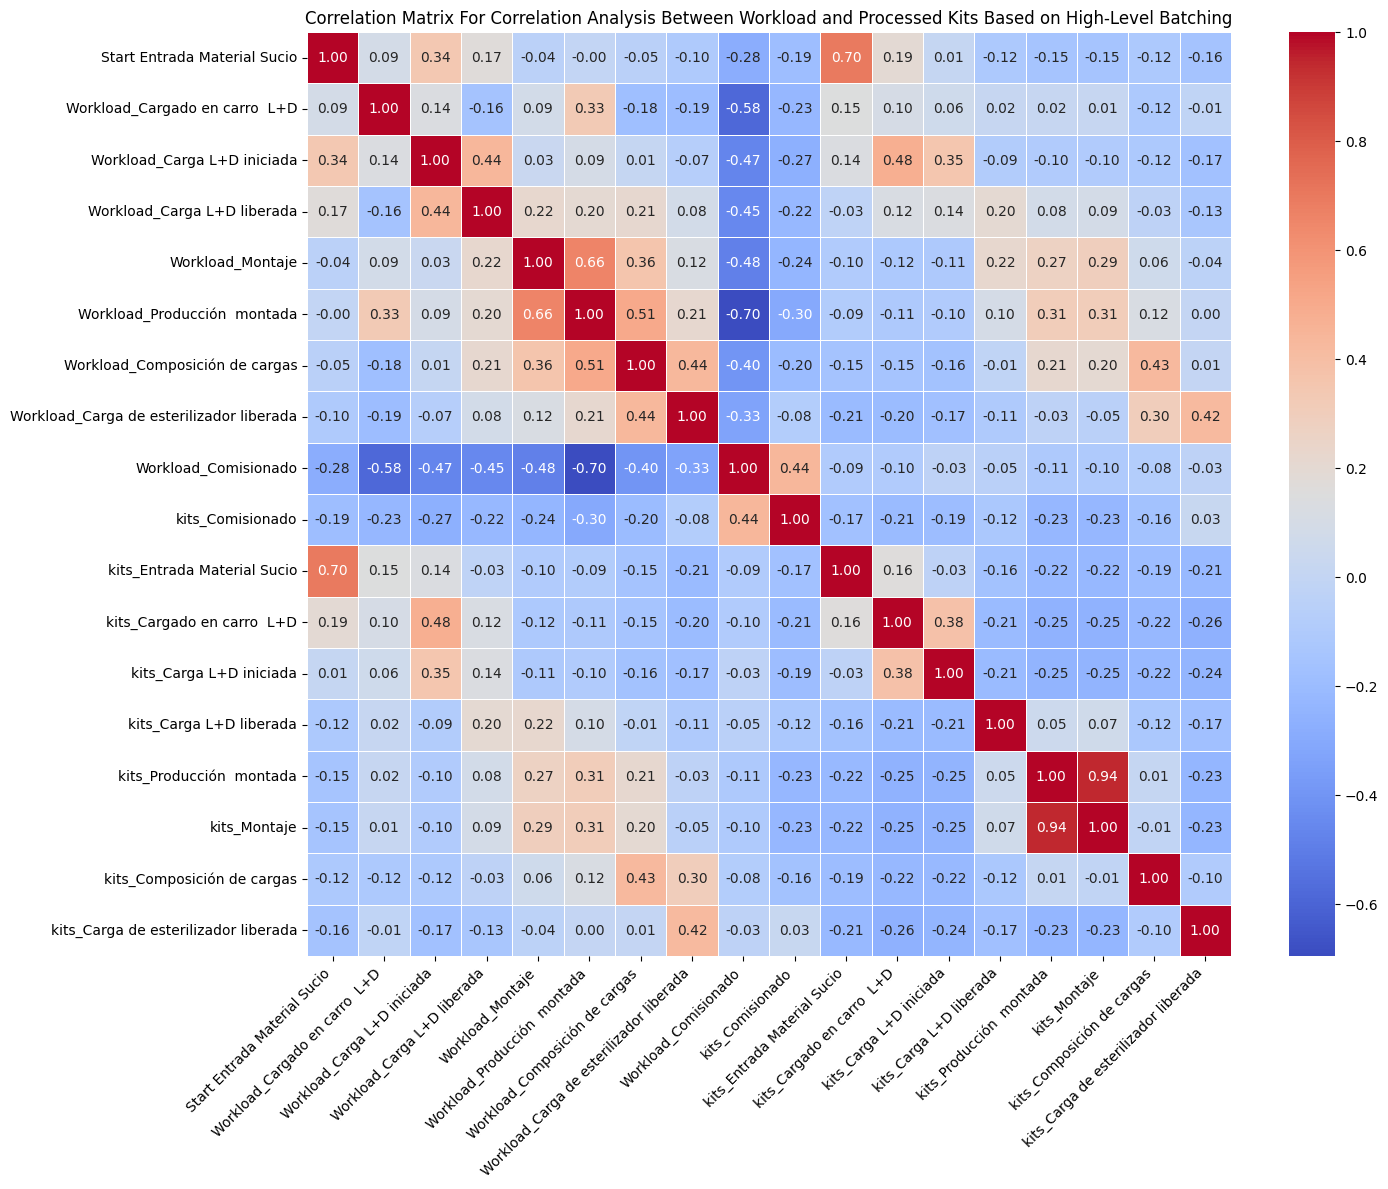

In [50]:
# Plotting the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_merged_norm_joint, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title('Correlation Matrix For Correlation Analysis Between Workload and Processed Kits Based on High-Level Batching')
plt.show()